In [547]:
import numpy as np
import pandas as pd
import pickle
import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from IPython.display import Image
import warnings

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

from pathlib import Path
data_folder = Path(r"C:\Users\memen\Documents\GB\GP_Python_libs\Lesson10")

In [452]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [453]:
x_test = pd.read_csv(data_folder / 'test.csv')
x_test = reduce_mem_usage(x_test)

xtr = pd.read_csv(data_folder / 'train.csv')
xtr = reduce_mem_usage(xtr)

ytr = xtr.Price

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%
Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


## Работа с категориальными переменными, заполнение пропусков и работа с выбросами

In [454]:
xtr['Base'] = 'train'
x_test['Base'] = 'test'
df = pd.concat([xtr, x_test])

In [455]:
df.head()

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
0,train,35,0.089040,B,B,7,NaN,0,9.0,1969,14038,6.0,29.442751,184966.937500,2.0,11,B,33,7976,5,47.981560
1,train,41,0.000070,B,B,7,240.0,1,9.0,1978,15053,8.0,40.049541,300009.437500,3.0,16,B,46,10309,1,65.683640
2,train,53,0.049637,B,B,8,229.0,1,12.0,1968,4765,0.0,29.197611,220925.906250,2.0,3,B,34,7759,0,44.947952
3,train,58,0.437885,B,B,8,1084.0,0,17.0,1977,5809,9.0,52.731510,175616.234375,2.0,5,B,23,5735,3,53.352982
4,train,99,0.012339,B,B,11,2078.0,2,12.0,1976,10783,7.0,23.776169,150226.531250,1.0,4,B,35,5776,1,39.649193


In [456]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 21 columns):
Base             15000 non-null object
DistrictId       15000 non-null int16
Ecology_1        15000 non-null float32
Ecology_2        15000 non-null category
Ecology_3        15000 non-null category
Floor            15000 non-null int8
Healthcare_1     7825 non-null float32
Helthcare_2      15000 non-null int8
HouseFloor       15000 non-null float32
HouseYear        15000 non-null int32
Id               15000 non-null int16
KitchenSquare    15000 non-null float32
LifeSquare       11846 non-null float32
Price            10000 non-null float32
Rooms            15000 non-null float32
Shops_1          15000 non-null int8
Shops_2          15000 non-null category
Social_1         15000 non-null int8
Social_2         15000 non-null int16
Social_3         15000 non-null int16
Square           15000 non-null float32
dtypes: category(3), float32(8), int16(4), int32(1), int8(4), object(1)
m

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000189812AD388>,
      dtype=object)

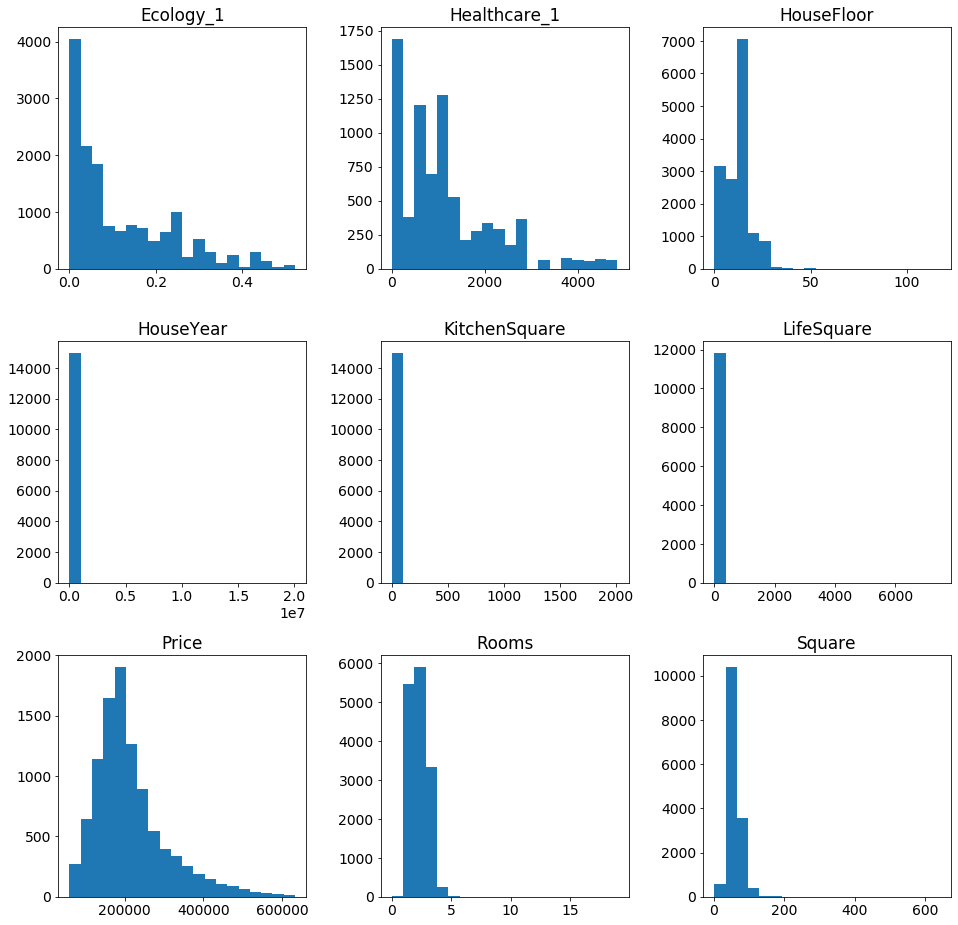

In [457]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'int64', 'int32'])
df_num_features.hist(figsize=(16,16), bins=20, grid=False)

## Разберемся с категориальными переменными

In [458]:
df['Ecology_2'].value_counts()

B    14855
A      145
Name: Ecology_2, dtype: int64

In [459]:
df['Ecology_3'].value_counts()

B    14576
A      424
Name: Ecology_3, dtype: int64

In [460]:
df['Shops_2'].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

In [461]:
cat_columns = ['Ecology_2', 'Ecology_3', 'Shops_2']

for category in cat_columns:
    df[category] = df[category].apply(lambda x: 1 if x=='A' else 0)

In [462]:
df.head()

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
0,train,35,0.089040,0,0,7,NaN,0,9.0,1969,14038,6.0,29.442751,184966.937500,2.0,11,0,33,7976,5,47.981560
1,train,41,0.000070,0,0,7,240.0,1,9.0,1978,15053,8.0,40.049541,300009.437500,3.0,16,0,46,10309,1,65.683640
2,train,53,0.049637,0,0,8,229.0,1,12.0,1968,4765,0.0,29.197611,220925.906250,2.0,3,0,34,7759,0,44.947952
3,train,58,0.437885,0,0,8,1084.0,0,17.0,1977,5809,9.0,52.731510,175616.234375,2.0,5,0,23,5735,3,53.352982
4,train,99,0.012339,0,0,11,2078.0,2,12.0,1976,10783,7.0,23.776169,150226.531250,1.0,4,0,35,5776,1,39.649193


## Работа с выбросами и заполнение пропусков

**Год постройки**

In [463]:
df.HouseYear.value_counts()

1977        3950
2016         477
2015         458
2017         449
2014         308
            ... 
1908           1
20052011       1
1947           1
1920           1
4968           1
Name: HouseYear, Length: 105, dtype: int64

In [464]:
df[df.HouseYear > 2020]

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
1497,train,109,0.136330,0,0,9,262.0,3,12.0,20052011,10814,9.0,20.239714,254084.531250,1.0,6,0,30,6141,10,37.265072
4189,train,147,0.319809,0,0,4,2857.0,5,9.0,4968,11607,5.0,28.360394,243028.609375,2.0,8,0,25,4756,16,44.791836


In [465]:
df.loc[df.HouseYear == 20052011, 'HouseYear'] = 2008
df.loc[df.HouseYear == 4968, 'HouseYear'] = 1968
df.loc[df.HouseYear > datetime.datetime.now().year, 'HouseYear'] = datetime.datetime.now().year

In [466]:
df.HouseYear.describe()

count    15000.000000
mean      1984.708200
std         18.466515
min       1908.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2020.000000
Name: HouseYear, dtype: float64

**Этаж**

In [467]:
df.Floor.describe()

count    15000.000000
mean         8.561800
std          5.323113
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         78.000000
Name: Floor, dtype: float64

In [468]:
df.HouseFloor.describe()

count    15000.0000
mean        12.6066
std          6.7803
min          0.0000
25%          9.0000
50%         12.0000
75%         17.0000
max        117.0000
Name: HouseFloor, dtype: float64

In [469]:
df.loc[(df.Floor > df.HouseFloor) | (df.Floor==0) | (df.HouseFloor==0), 'Floor'].count()

2709

In [470]:
df.loc[(df.Floor > df.HouseFloor), 'Floor'].count()

2709

**Кажется, в некоторых кейсах перепутаны этаж и этажность дома. Сначала поправлю это, потом подумаю, что делать с 0 этажом**

In [471]:
condition = df.Floor > df.HouseFloor
df['Floor'],df['HouseFloor']=np.where(condition,(df['HouseFloor'],df['Floor']),(df['Floor'],df['HouseFloor']))

In [472]:
df.loc[(df.Floor > df.HouseFloor), 'Floor'].count()

0

In [473]:
df[(df.Floor==0) | (df.HouseFloor==0)]

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
7,train,74,0.075779,0,0,0.0,NaN,0,14.0,1977,11993,0.0,NaN,221244.15625,2.0,2,0,6,1437,3,80.312927
23,train,54,0.006076,0,0,0.0,645.0,6,2.0,1977,6641,0.0,NaN,571069.06250,3.0,6,0,30,5285,0,118.907608
26,train,27,0.072158,0,0,0.0,NaN,0,17.0,2018,4378,0.0,0.641822,337299.87500,3.0,0,1,2,629,1,106.958870
39,train,23,0.034656,0,0,0.0,NaN,0,16.0,1977,9371,0.0,NaN,229778.06250,2.0,0,0,0,168,0,60.503250
44,train,38,0.060753,0,0,0.0,520.0,0,20.0,2017,10521,0.0,106.340401,435462.06250,3.0,7,0,15,2787,2,104.211395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4856,test,27,0.017647,0,0,0.0,NaN,0,10.0,1977,10262,0.0,NaN,NaN,2.0,0,0,2,469,0,69.196442
4887,test,88,0.127376,0,0,0.0,NaN,3,20.0,1977,12116,0.0,NaN,NaN,3.0,9,0,43,8429,3,89.549561
4892,test,58,0.437885,0,0,0.0,1084.0,0,4.0,1977,16357,0.0,NaN,NaN,1.0,5,0,23,5735,3,49.205978
4976,test,95,0.000699,0,0,0.0,4129.0,0,6.0,1977,4723,0.0,NaN,NaN,1.0,3,0,14,3369,24,45.542938


**Мне кажется, нулевой этаж - это может быть подвальный этаж или т.н. ground floor - с этим я ничего пока делать не буду**

In [474]:
display(df.Floor.describe(), df.HouseFloor.describe())

count    15000.000000
mean         7.746267
std          5.355032
min          0.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         46.000000
Name: Floor, dtype: float64

count    15000.000000
mean        13.422133
std          6.140455
min          1.000000
25%          9.000000
50%         14.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [475]:
df[df.HouseFloor>46].sort_values(by='HouseFloor')

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
3974,train,20,0.019509,0,0,22.0,176.0,5,47.0,2012,6502,14.0,103.637321,450706.562500,1.0,5,0,37,7687,11,126.389519
2781,train,76,0.000000,0,0,42.0,1786.0,1,48.0,2016,1674,5.0,41.044132,411691.500000,2.0,5,0,7,1660,39,74.344673
7728,train,24,0.111627,0,0,22.0,1970.0,2,48.0,2011,7453,12.0,62.455482,179396.515625,3.0,3,0,50,12238,8,126.621361
1587,test,76,0.000000,0,0,38.0,1786.0,1,48.0,2010,5707,5.0,38.740059,NaN,2.0,5,0,7,1660,39,73.363525
3711,test,76,0.000000,0,0,46.0,1786.0,1,48.0,2002,414,5.0,41.175949,NaN,2.0,5,0,7,1660,39,67.609810
3909,test,76,0.000000,0,0,32.0,1786.0,1,48.0,2011,1397,4.0,118.055344,NaN,3.0,5,0,7,1660,39,221.138763
4698,test,17,0.000000,0,0,22.0,46.0,1,78.0,1989,15759,10.0,37.744743,NaN,2.0,1,0,25,5027,4,57.601871
6131,train,5,0.150818,0,0,6.0,2643.0,4,99.0,1977,10806,1.0,48.709602,296127.125000,1.0,5,0,16,3433,4,51.944588
8599,train,74,0.075779,0,0,5.0,NaN,0,99.0,1977,9300,9.0,74.579811,243329.906250,2.0,2,0,6,1437,3,71.747871
651,test,27,0.072158,0,0,18.0,NaN,0,99.0,1977,15864,9.0,47.098812,NaN,3.0,0,1,2,629,1,47.722836


**Кажется, что этажность выше 48 - выбросы, особенно для домов таких лет постройки**

Дальше работа с конкретными кейсами

In [476]:
df[df.HouseYear == 1989].sort_values(by='HouseFloor')

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
1377,train,83,0.007720,0,0,8.0,NaN,0,9.0,1989,15076,6.0,25.123600,180730.843750,1.0,4,0,38,4788,2,37.187057
675,train,28,0.118537,0,0,2.0,1183.0,1,12.0,1989,4663,8.0,21.471144,174131.625000,1.0,0,0,30,6207,1,42.985134
2362,test,128,0.041116,0,0,4.0,NaN,1,12.0,1989,13478,8.0,25.285683,NaN,1.0,4,0,53,14892,4,42.444695
2655,test,152,0.042032,0,0,3.0,1940.0,2,13.0,1989,7004,8.0,40.150196,NaN,3.0,5,0,37,6856,84,68.964691
7297,train,28,0.118537,0,0,12.0,1183.0,1,14.0,1989,16035,8.0,25.622173,172378.562500,1.0,0,0,30,6207,1,44.410793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3065,train,12,0.090799,0,0,10.0,NaN,5,22.0,1989,13522,10.0,21.668680,196082.484375,1.0,15,0,74,19083,2,41.245411
534,test,55,0.041365,0,0,4.0,NaN,1,22.0,1989,5573,9.0,48.303604,NaN,3.0,4,0,31,5569,0,80.271935
4737,test,7,0.130618,0,0,22.0,900.0,1,23.0,1989,15897,9.0,47.516460,NaN,3.0,9,0,39,10418,9,78.400261
4997,test,12,0.090799,0,0,22.0,NaN,5,23.0,1989,5783,9.0,48.282623,NaN,3.0,15,0,74,19083,2,77.842178


In [477]:
df.loc[df.HouseFloor==78, 'HouseFloor'] = 23

In [478]:
df[df.HouseYear == 1977].sort_values(by='HouseFloor').tail(10)

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
9613,train,38,0.060753,0,0,1.0,520.0,0,28.0,1977,7657,1.0,4.618547,483283.50000,1.0,7,0,15,2787,2,4.502784
5047,train,34,0.069753,0,0,25.0,NaN,1,30.0,1977,2377,10.0,NaN,343821.93750,2.0,11,0,53,13670,4,57.350700
4544,test,24,0.111627,0,0,28.0,1970.0,2,31.0,1977,3389,10.0,NaN,NaN,2.0,3,0,50,12238,8,79.624428
8340,train,31,0.151346,0,1,15.0,830.0,4,40.0,1977,15270,16.0,46.632999,547586.06250,2.0,1,0,32,5889,10,81.042938
8357,train,31,0.151346,0,1,33.0,830.0,4,40.0,1977,8016,10.0,24.050533,389554.06250,1.0,1,0,32,5889,10,59.519897
3330,train,31,0.151346,0,1,32.0,830.0,4,40.0,1977,3298,10.0,21.551876,393799.53125,1.0,1,0,32,5889,10,57.551693
651,test,27,0.072158,0,0,18.0,NaN,0,99.0,1977,15864,9.0,47.098812,NaN,3.0,0,1,2,629,1,47.722836
8599,train,74,0.075779,0,0,5.0,NaN,0,99.0,1977,9300,9.0,74.579811,243329.90625,2.0,2,0,6,1437,3,71.747871
6131,train,5,0.150818,0,0,6.0,2643.0,4,99.0,1977,10806,1.0,48.709602,296127.12500,1.0,5,0,16,3433,4,51.944588
8854,train,30,0.000078,0,0,8.0,1046.0,3,117.0,1977,78,1.0,66.811790,207248.37500,2.0,23,0,22,6398,141,65.773750


In [479]:
df.loc[df.HouseFloor==99, 'HouseFloor'] = 40
df.loc[df.HouseFloor==117, 'HouseFloor'] = 17

In [480]:
df['HouseFloor'].describe()

count    15000.000000
mean        13.400000
std          5.949266
min          1.000000
25%          9.000000
50%         14.000000
75%         17.000000
max         48.000000
Name: HouseFloor, dtype: float64

**Площади**

**Общая площадь**

In [481]:
df.Square.describe()

count    15000.000000
mean        56.360546
std         20.423899
min          1.136859
25%         41.814370
50%         52.645758
75%         66.036606
max        641.065186
Name: Square, dtype: float64

In [482]:
df[df.Square<20].sort_values(by='Square')

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
6392,train,1,0.007122,0,0,1.0,NaN,0,3.0,1977,14786,1.0,4.525736,181434.828125,1.0,1,0,1,264,0,1.136859
66,test,53,0.049637,0,0,1.0,229.0,1,1.0,1977,9011,1.0,1.353573,NaN,1.0,3,0,34,7759,0,1.378543
4902,test,45,0.195781,0,0,1.0,NaN,3,1.0,1977,1420,1.0,2.900371,NaN,1.0,2,0,23,5212,6,1.975769
8283,train,34,0.069753,0,0,4.0,NaN,1,21.0,1977,15744,1.0,2.642219,458378.781250,1.0,11,0,53,13670,4,1.988943
4490,test,27,0.011654,0,0,2.0,NaN,0,17.0,1977,1165,1.0,1.899119,NaN,1.0,0,0,4,915,0,2.372101
4853,train,27,0.017647,0,0,0.0,NaN,0,1.0,1977,3224,0.0,0.873147,126596.945312,0.0,0,0,2,469,0,2.377248
1608,train,6,0.243205,0,0,3.0,540.0,0,25.0,2014,10202,1.0,4.604943,137597.593750,1.0,0,0,5,1564,0,2.596351
608,test,30,0.000078,0,0,1.0,1046.0,3,2.0,1977,16401,1.0,4.338756,NaN,1.0,23,0,22,6398,141,2.645046
4713,test,6,0.243205,0,0,17.0,540.0,0,18.0,2014,170,1.0,61.468563,NaN,2.0,0,0,5,1564,0,2.900586
9294,train,45,0.195781,0,0,1.0,NaN,3,3.0,1977,6782,1.0,5.257278,438005.187500,1.0,2,0,23,5212,6,2.954309


**Буду считать, что ошиблись в разрядности. Все, что меньше 10, умножаю на 10**

In [483]:
df.loc[df.Square<10, 'Square'] = df.loc[df.Square<10, 'Square'] * 10

In [484]:
df[df.Square>200].sort_values(by='Square')

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
9910,train,27,0.041116,0,0,1.0,NaN,1,2.0,2013,16568,25.0,201.627365,528560.500000,4.0,4,0,53,14892,4,200.334534
1981,train,27,0.211401,0,0,2.0,NaN,0,3.0,2008,7917,0.0,211.231125,302211.250000,0.0,1,0,9,1892,0,212.932358
3909,test,76,0.000000,0,0,32.0,1786.0,1,48.0,2011,1397,4.0,118.055344,NaN,3.0,5,0,7,1660,39,221.138763
3217,test,27,0.041116,0,0,2.0,NaN,1,2.0,2017,4058,16.0,104.113556,NaN,6.0,4,0,53,14892,4,223.453690
1982,train,86,0.161976,0,1,12.0,4508.0,3,37.0,2011,5548,26.0,233.949310,455264.875000,5.0,7,0,31,7010,5,275.645294
4690,train,102,0.238617,0,0,4.0,705.0,3,4.0,2016,2307,10.0,410.639740,90470.429688,1.0,6,0,26,3889,6,409.425171
4262,train,9,0.161532,0,0,17.0,30.0,2,18.0,1977,28,1.0,NaN,187717.250000,2.0,4,0,25,5648,1,604.705994
6977,train,30,0.000078,0,0,19.0,1046.0,3,20.0,2019,11602,10.0,638.163208,133529.687500,2.0,23,0,22,6398,141,641.065186


**Площадь больше 400 понижаю в разрядности**

In [485]:
df.loc[df.Square>400, 'Square'] = df.loc[df.Square>400, 'Square'] * 0.1

In [486]:
df.KitchenSquare.describe()

count    15000.000000
mean         6.174467
std         24.017548
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

**Площадь кухни - оч странная переменная. При значениях от 43 она равна общей площади.
Я попробую сделать 3 доп переменные: площадь кухни 4-6, 7-10, 11-32**

In [487]:
df.loc[(df.KitchenSquare > 32) & (df.KitchenSquare < 42), 'KitchenSquare'] = df.loc[(df.KitchenSquare > 32) & (df.KitchenSquare < 42), 'KitchenSquare'] * 0.1

In [488]:
df['Kitchen1'] = df['KitchenSquare'].apply(lambda x: 1 if (x>=4 and x<=6) else 0)

In [489]:
df['Kitchen2'] = df['KitchenSquare'].apply(lambda x: 1 if (x>=7 and x<=10) else 0)

In [490]:
df['Kitchen3'] = df['KitchenSquare'].apply(lambda x: 1 if (x>=11 and x<=42) else 0)

In [491]:
df.head()

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square,Kitchen1,Kitchen2,Kitchen3
0,train,35,0.089040,0,0,7.0,NaN,0,9.0,1969,14038,6.0,29.442751,184966.937500,2.0,11,0,33,7976,5,47.981560,1,0,0
1,train,41,0.000070,0,0,7.0,240.0,1,9.0,1978,15053,8.0,40.049541,300009.437500,3.0,16,0,46,10309,1,65.683640,0,1,0
2,train,53,0.049637,0,0,8.0,229.0,1,12.0,1968,4765,0.0,29.197611,220925.906250,2.0,3,0,34,7759,0,44.947952,0,0,0
3,train,58,0.437885,0,0,8.0,1084.0,0,17.0,1977,5809,9.0,52.731510,175616.234375,2.0,5,0,23,5735,3,53.352982,0,1,0
4,train,99,0.012339,0,0,11.0,2078.0,2,12.0,1976,10783,7.0,23.776169,150226.531250,1.0,4,0,35,5776,1,39.649193,0,1,0


**Выбросы жилой площади я обработаю подобно общей площади. Дальше посмотрю, есть ли случаи, когда жилая больше общей - может быть, поменяю местами. Попробую заполнить пропуски жилой площади, но не уверена, что оставлю эту переменную для модели**

In [492]:
df.LifeSquare.describe()

count    11846.000000
mean        36.851711
std         71.120201
min          0.333490
25%         22.896130
50%         32.822811
75%         45.144627
max       7480.592285
Name: LifeSquare, dtype: float64

In [493]:
df.loc[df.LifeSquare < 1, 'LifeSquare'] = df.loc[df.LifeSquare < 1, 'LifeSquare'] * 100

In [494]:
df.loc[df.LifeSquare < 6, 'LifeSquare'] = df.loc[df.LifeSquare < 6, 'LifeSquare'] * 10

In [495]:
condition = (df.LifeSquare >=150) & (df.Square < 81)
df.loc[condition, 'LifeSquare'] = df.loc[condition, 'LifeSquare'] * 0.1

In [496]:
df.loc[df.LifeSquare > 1000, 'LifeSquare'] = df.loc[df.LifeSquare > 1000, 'LifeSquare'] * 0.01

In [497]:
df[df.LifeSquare>=150].sort_values(by='LifeSquare')

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square,Kitchen1,Kitchen2,Kitchen3
5444,train,62,0.072158,0,0,1.0,NaN,0,3.0,2005,14181,1.0,153.685837,502523.562500,3.0,0,1,2,629,1,156.636581,0,0,0
4047,train,23,0.014073,0,0,3.0,NaN,0,4.0,1977,15362,1.0,161.155273,228572.515625,1.0,0,0,2,475,0,163.286972,0,0,0
2603,train,23,0.014073,0,0,3.0,NaN,0,5.0,1977,5621,12.0,161.504227,207007.953125,3.0,0,0,2,475,0,163.495331,0,0,1
8913,train,30,0.000078,0,0,2.0,1046.0,3,3.0,1977,2603,0.0,164.526764,207407.359375,3.0,23,0,22,6398,141,162.587891,0,0,0
2557,test,17,0.093443,0,0,0.0,3300.0,2,4.0,2013,16053,0.0,169.901703,NaN,4.0,4,0,23,4635,5,168.729034,0,0,0
3651,train,30,0.000078,0,0,2.0,1046.0,3,2.0,2018,5300,1.0,170.713654,200800.671875,3.0,23,0,22,6398,141,169.509933,0,0,0
1641,train,151,0.236108,0,0,10.0,NaN,3,12.0,1958,11055,15.0,174.837082,232766.187500,1.0,10,0,16,3893,27,174.649521,0,0,1
9910,train,27,0.041116,0,0,1.0,NaN,1,2.0,2013,16568,25.0,201.627365,528560.500000,4.0,4,0,53,14892,4,200.334534,0,0,1
1981,train,27,0.211401,0,0,2.0,NaN,0,3.0,2008,7917,0.0,211.231125,302211.250000,0.0,1,0,9,1892,0,212.932358,0,0,0
1982,train,86,0.161976,0,1,12.0,4508.0,3,37.0,2011,5548,26.0,233.949310,455264.875000,5.0,7,0,31,7010,5,275.645294,0,0,1


In [498]:
df[df.LifeSquare > df.Square].sort_values(by='LifeSquare')

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square,Kitchen1,Kitchen2,Kitchen3
2,test,190,0.000000,0,0,2.0,4702.0,5,5.0,1909,5480,12.0,15.948246,NaN,1.0,5,0,30,7538,87,13.597818,0,0,1
4739,train,81,0.319809,0,0,4.0,2857.0,5,5.0,1960,12676,7.0,15.988890,78388.804688,3.0,8,0,25,4756,16,13.784864,0,1,0
5617,train,57,0.133215,0,0,5.0,1406.0,3,5.0,1962,15877,8.0,16.698570,77835.187500,3.0,4,1,49,11395,3,16.547241,0,1,0
3166,train,150,0.300323,0,0,7.0,NaN,1,12.0,1982,15127,8.0,20.036232,74222.109375,1.0,9,0,52,10311,6,17.046188,0,1,0
8283,train,34,0.069753,0,0,4.0,NaN,1,21.0,1977,15744,1.0,26.422186,458378.781250,1.0,11,0,53,13670,4,19.889427,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8913,train,30,0.000078,0,0,2.0,1046.0,3,3.0,1977,2603,0.0,164.526764,207407.359375,3.0,23,0,22,6398,141,162.587891,0,0,0
2557,test,17,0.093443,0,0,0.0,3300.0,2,4.0,2013,16053,0.0,169.901703,NaN,4.0,4,0,23,4635,5,168.729034,0,0,0
3651,train,30,0.000078,0,0,2.0,1046.0,3,2.0,2018,5300,1.0,170.713654,200800.671875,3.0,23,0,22,6398,141,169.509933,0,0,0
1641,train,151,0.236108,0,0,10.0,NaN,3,12.0,1958,11055,15.0,174.837082,232766.187500,1.0,10,0,16,3893,27,174.649521,0,0,1


In [499]:
condition = df.LifeSquare > df.Square
df['LifeSquare'],df['Square']=np.where(condition,(df['Square'],df['LifeSquare']),(df['LifeSquare'],df['Square']))

**К пропускам жилой площади вернусь позже**

**Комнаты**

In [500]:
df['Rooms'].value_counts()

2.0     5910
1.0     5474
3.0     3334
4.0      240
5.0       25
0.0       10
6.0        3
10.0       2
19.0       1
17.0       1
Name: Rooms, dtype: int64

**0 и больше 6 - выбросы. Я восстановлю количество комнат по соотношению общей площади к количеству комнат, ОТДЕЛЬНО НА ТРЕЙНЕ, ОТДЕЛЬНО НА ТЕСТЕ**

In [501]:
df['Rooms'] = df['Rooms'].replace([0,10,19,17], None)

In [502]:
df['Rooms'].value_counts()

2.0    5918
1.0    5477
3.0    3337
4.0     240
5.0      25
6.0       3
Name: Rooms, dtype: int64

In [503]:
df['Mean_room_square'] = df['Square'] / df['Rooms']

In [504]:
df['Mean_room_square']=df['Mean_room_square'].fillna(df.groupby(['HouseYear', 'DistrictId', 'Base'])['Mean_room_square'].transform('median'))

In [505]:
df['Mean_room_square']=df['Mean_room_square'].fillna(df.groupby(['DistrictId', 'Base'])['Mean_room_square'].transform('median'))

In [506]:
df['Mean_room_square']=df['Mean_room_square'].fillna(df.groupby(['HouseYear', 'Base'])['Mean_room_square'].transform('median'))

In [507]:
df['Mean_room_square'].describe()

count    15000.000000
mean        32.457607
std          9.997607
min          5.329630
25%         25.578005
50%         30.898396
75%         38.933414
max        174.837082
Name: Mean_room_square, dtype: float64

In [508]:
df['Rooms']=df['Rooms'].fillna(df['Square']/df['Mean_room_square'])

In [509]:
df['Rooms'] = df['Rooms'].apply(lambda x: int(x) if x >=1 else 1)

In [510]:
df['Rooms'].value_counts()

2    5918
1    5477
3    3337
4     240
5      25
6       3
Name: Rooms, dtype: int64

In [450]:
df['Rooms'].count()

15000

**Теперь возвращаемся к пропускам жилой площади**

In [511]:
df['Mean_room_Lsquare'] = df['LifeSquare'] / df['Rooms']

In [512]:
df['Mean_room_Lsquare']=df['Mean_room_Lsquare'].fillna(df.groupby(['HouseYear', 'DistrictId', 'Base'])['Mean_room_Lsquare'].transform('median'))

In [513]:
df['Mean_room_Lsquare'].count()

14890

In [514]:
df['Mean_room_Lsquare']=df['Mean_room_Lsquare'].fillna(df.groupby(['HouseYear', 'Base'])['Mean_room_Lsquare'].transform('median'))

In [515]:
df['Mean_room_Lsquare'].count()

15000

**Заполню пропуски жилой площади**

In [516]:
df['LifeSquare']=df['LifeSquare'].fillna(df['Mean_room_Lsquare'] * df['Rooms'])

In [517]:
df['LifeSquare'].describe()

count    15000.000000
mean        40.048882
std         19.742527
min          5.501955
25%         25.883265
50%         34.043959
75%         48.745141
max        276.014709
Name: LifeSquare, dtype: float64

In [518]:
df[df.LifeSquare > df.Square].sort_values(by='LifeSquare')

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square,Kitchen1,Kitchen2,Kitchen3,Mean_room_square,Mean_room_Lsquare
7247,train,27,0.211401,0,0,13.0,NaN,0,22.0,1977,13445,1.0,27.720629,96865.320312,1,1,0,9,1892,0,27.128761,0,0,0,27.128761,27.720629
501,train,27,0.072158,0,0,0.0,NaN,0,25.0,1977,15923,0.0,27.720629,114256.234375,1,0,1,2,629,1,26.553188,0,0,0,26.553188,27.720629
4234,test,34,0.069753,0,0,2.0,NaN,1,4.0,2015,15846,1.0,27.769264,NaN,1,11,0,53,13670,4,26.719723,0,0,0,26.719723,27.769264
1436,test,27,0.211401,0,0,10.0,NaN,0,19.0,1977,12833,0.0,28.314238,NaN,1,1,0,9,1892,0,27.658463,0,0,0,27.658463,28.314238
3954,train,27,0.211401,0,0,8.0,NaN,0,16.0,2016,5210,1.0,28.604750,74982.609375,1,1,0,9,1892,0,27.245731,0,0,0,27.245731,28.604750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,test,23,0.014073,0,0,2.0,NaN,0,2.0,2015,10793,0.0,161.610321,NaN,6,0,0,2,475,0,110.750229,0,0,0,18.458372,26.935055
4843,test,120,0.341072,0,0,1.0,2300.0,3,7.0,1977,9455,1.0,164.736938,NaN,3,11,0,27,5664,48,93.513054,0,0,0,31.171019,54.912312
6201,train,17,0.093443,0,0,0.0,3300.0,2,12.0,1977,10678,0.0,203.050232,531049.750000,4,4,0,23,4635,5,170.016876,0,0,0,42.504219,50.762558
9580,train,38,0.060753,0,0,16.0,520.0,0,20.0,1977,589,10.0,276.014709,372468.406250,3,7,0,15,2787,2,88.482544,0,1,0,29.494181,92.004898


In [519]:
df.loc[df.LifeSquare > df.Square, 'LifeSquare'] = df.loc[df.LifeSquare > df.Square, 'Square']

**Удаляю фичи, которые не буду использовать**

In [520]:
df = df.drop(columns=['Healthcare_1', 'KitchenSquare'])

In [521]:
pd.set_option('display.max_columns', None)
df.head()

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Helthcare_2,HouseFloor,HouseYear,Id,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square,Kitchen1,Kitchen2,Kitchen3,Mean_room_square,Mean_room_Lsquare
0,train,35,0.089040,0,0,7.0,0,9.0,1969,14038,29.442751,184966.937500,2,11,0,33,7976,5,47.981560,1,0,0,23.990780,14.721375
1,train,41,0.000070,0,0,7.0,1,9.0,1978,15053,40.049541,300009.437500,3,16,0,46,10309,1,65.683640,0,1,0,21.894547,13.349847
2,train,53,0.049637,0,0,8.0,1,12.0,1968,4765,29.197611,220925.906250,2,3,0,34,7759,0,44.947952,0,0,0,22.473976,14.598805
3,train,58,0.437885,0,0,8.0,0,17.0,1977,5809,52.731510,175616.234375,2,5,0,23,5735,3,53.352982,0,1,0,26.676491,26.365755
4,train,99,0.012339,0,0,11.0,2,12.0,1976,10783,23.776169,150226.531250,1,4,0,35,5776,1,39.649193,0,1,0,39.649193,23.776169


## Новые фичи

In [522]:
df['Price_per_square'] = df['Price'] / df['Square']

In [523]:
column_unit = [['Median_pps_per_district', 'DistrictId'], ['Median_pps_per_Hyear', 'HouseYear'], \
               ['Median_pps_per_Hfloor', 'HouseFloor'], ['Median_pps_per_NRooms', 'Rooms']]

for i in range(4):
    df[column_unit[i][0]] = None
    
for i in range(4):
    df[column_unit[i][0]] = df[column_unit[i][0]].fillna(df.groupby([column_unit[i][1]])['Price_per_square'].transform('median')) 

In [524]:
df['Price_per_Lifesquare'] = df['Price'] / df['LifeSquare']

In [525]:
column_unit = [['Median_ppls_per_district', 'DistrictId'], ['Median_ppls_per_Hyear', 'HouseYear'], \
               ['Median_ppls_per_Hfloor', 'HouseFloor'], ['Median_ppls_per_NRooms', 'Rooms']]

for i in range(4):
    df[column_unit[i][0]] = None
    
for i in range(4):
    df[column_unit[i][0]] = df[column_unit[i][0]].fillna(df.groupby([column_unit[i][1]])['Price_per_square'].transform('median')) 

In [526]:
column_unit = [['Med_price_per_district', 'DistrictId'], ['Med_price_per_Hyear', 'HouseYear'], \
               ['Med_price_per_Hfloor', 'HouseFloor'], ['Med_price_per_NRooms', 'Rooms']]

for i in range(4):
    df[column_unit[i][0]] = None
    
for i in range(4):
    df[column_unit[i][0]] = df[column_unit[i][0]].fillna(df.groupby([column_unit[i][1]])['Price'].transform('median')) 

In [527]:
df.head()

,Base,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Helthcare_2,HouseFloor,HouseYear,Id,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square,Kitchen1,Kitchen2,Kitchen3,Mean_room_square,Mean_room_Lsquare,Price_per_square,Median_pps_per_district,Median_pps_per_Hyear,Median_pps_per_Hfloor,Median_pps_per_NRooms,Price_per_Lifesquare,Median_ppls_per_district,Median_ppls_per_Hyear,Median_ppls_per_Hfloor,Median_ppls_per_NRooms,Med_price_per_district,Med_price_per_Hyear,Med_price_per_Hfloor,Med_price_per_NRooms
0,train,35,0.089040,0,0,7.0,0,9.0,1969,14038,29.442751,184966.937500,2,11,0,33,7976,5,47.981560,1,0,0,23.990780,14.721375,3854.958740,4358.274902,4473.255371,4315.832031,3900.695068,6282.257324,4358.274902,4473.255371,4315.832031,3900.695068,203602.406250,191552.406250,195829.12500,200320.75000
1,train,41,0.000070,0,0,7.0,1,9.0,1978,15053,40.049541,300009.437500,3,16,0,46,10309,1,65.683640,0,1,0,21.894547,13.349847,4567.491211,4437.304199,4317.685059,4315.832031,3854.768311,7490.958008,4437.304199,4317.685059,4315.832031,3854.768311,210694.843750,216660.187500,195829.12500,268864.50000
2,train,53,0.049637,0,0,8.0,1,12.0,1968,4765,29.197611,220925.906250,2,3,0,34,7759,0,44.947952,0,0,0,22.473976,14.598805,4915.149414,4830.233887,4433.699707,4191.155273,3900.695068,7566.574707,4830.233887,4433.699707,4191.155273,3900.695068,245978.796875,190404.515625,197485.34375,200320.75000
3,train,58,0.437885,0,0,8.0,0,17.0,1977,5809,52.731510,175616.234375,2,5,0,23,5735,3,53.352982,0,1,0,26.676491,26.365755,3291.591797,2949.975342,2892.705078,3152.918945,3900.695068,3330.385010,2949.975342,2892.705078,3152.918945,3900.695068,151557.906250,168658.343750,183447.62500,200320.75000
4,train,99,0.012339,0,0,11.0,2,12.0,1976,10783,23.776169,150226.531250,1,4,0,35,5776,1,39.649193,0,1,0,39.649193,23.776169,3788.892578,3992.031250,4367.263184,4191.155273,3935.400879,6318.365723,3992.031250,4367.263184,4191.155273,3935.400879,178829.171875,210694.843750,197485.34375,155000.03125


## Таргет

In [528]:
df.Price.describe()

count     10000.000000
mean     214139.218750
std       92872.304688
min       59174.777344
25%      153872.625000
50%      192269.656250
75%      249135.468750
max      633233.437500
Name: Price, dtype: float64

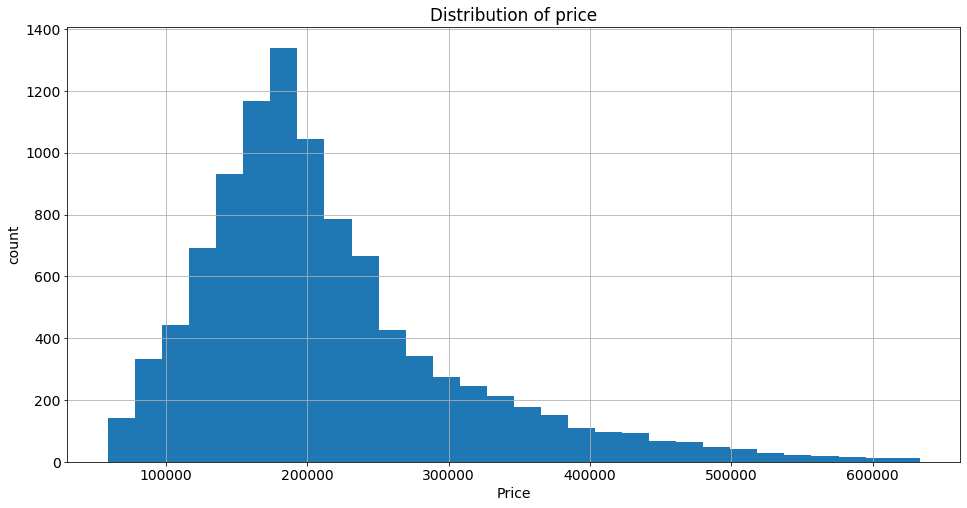

In [529]:
plt.figure(figsize = (16, 8))

df.Price.hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of price')
plt.show()

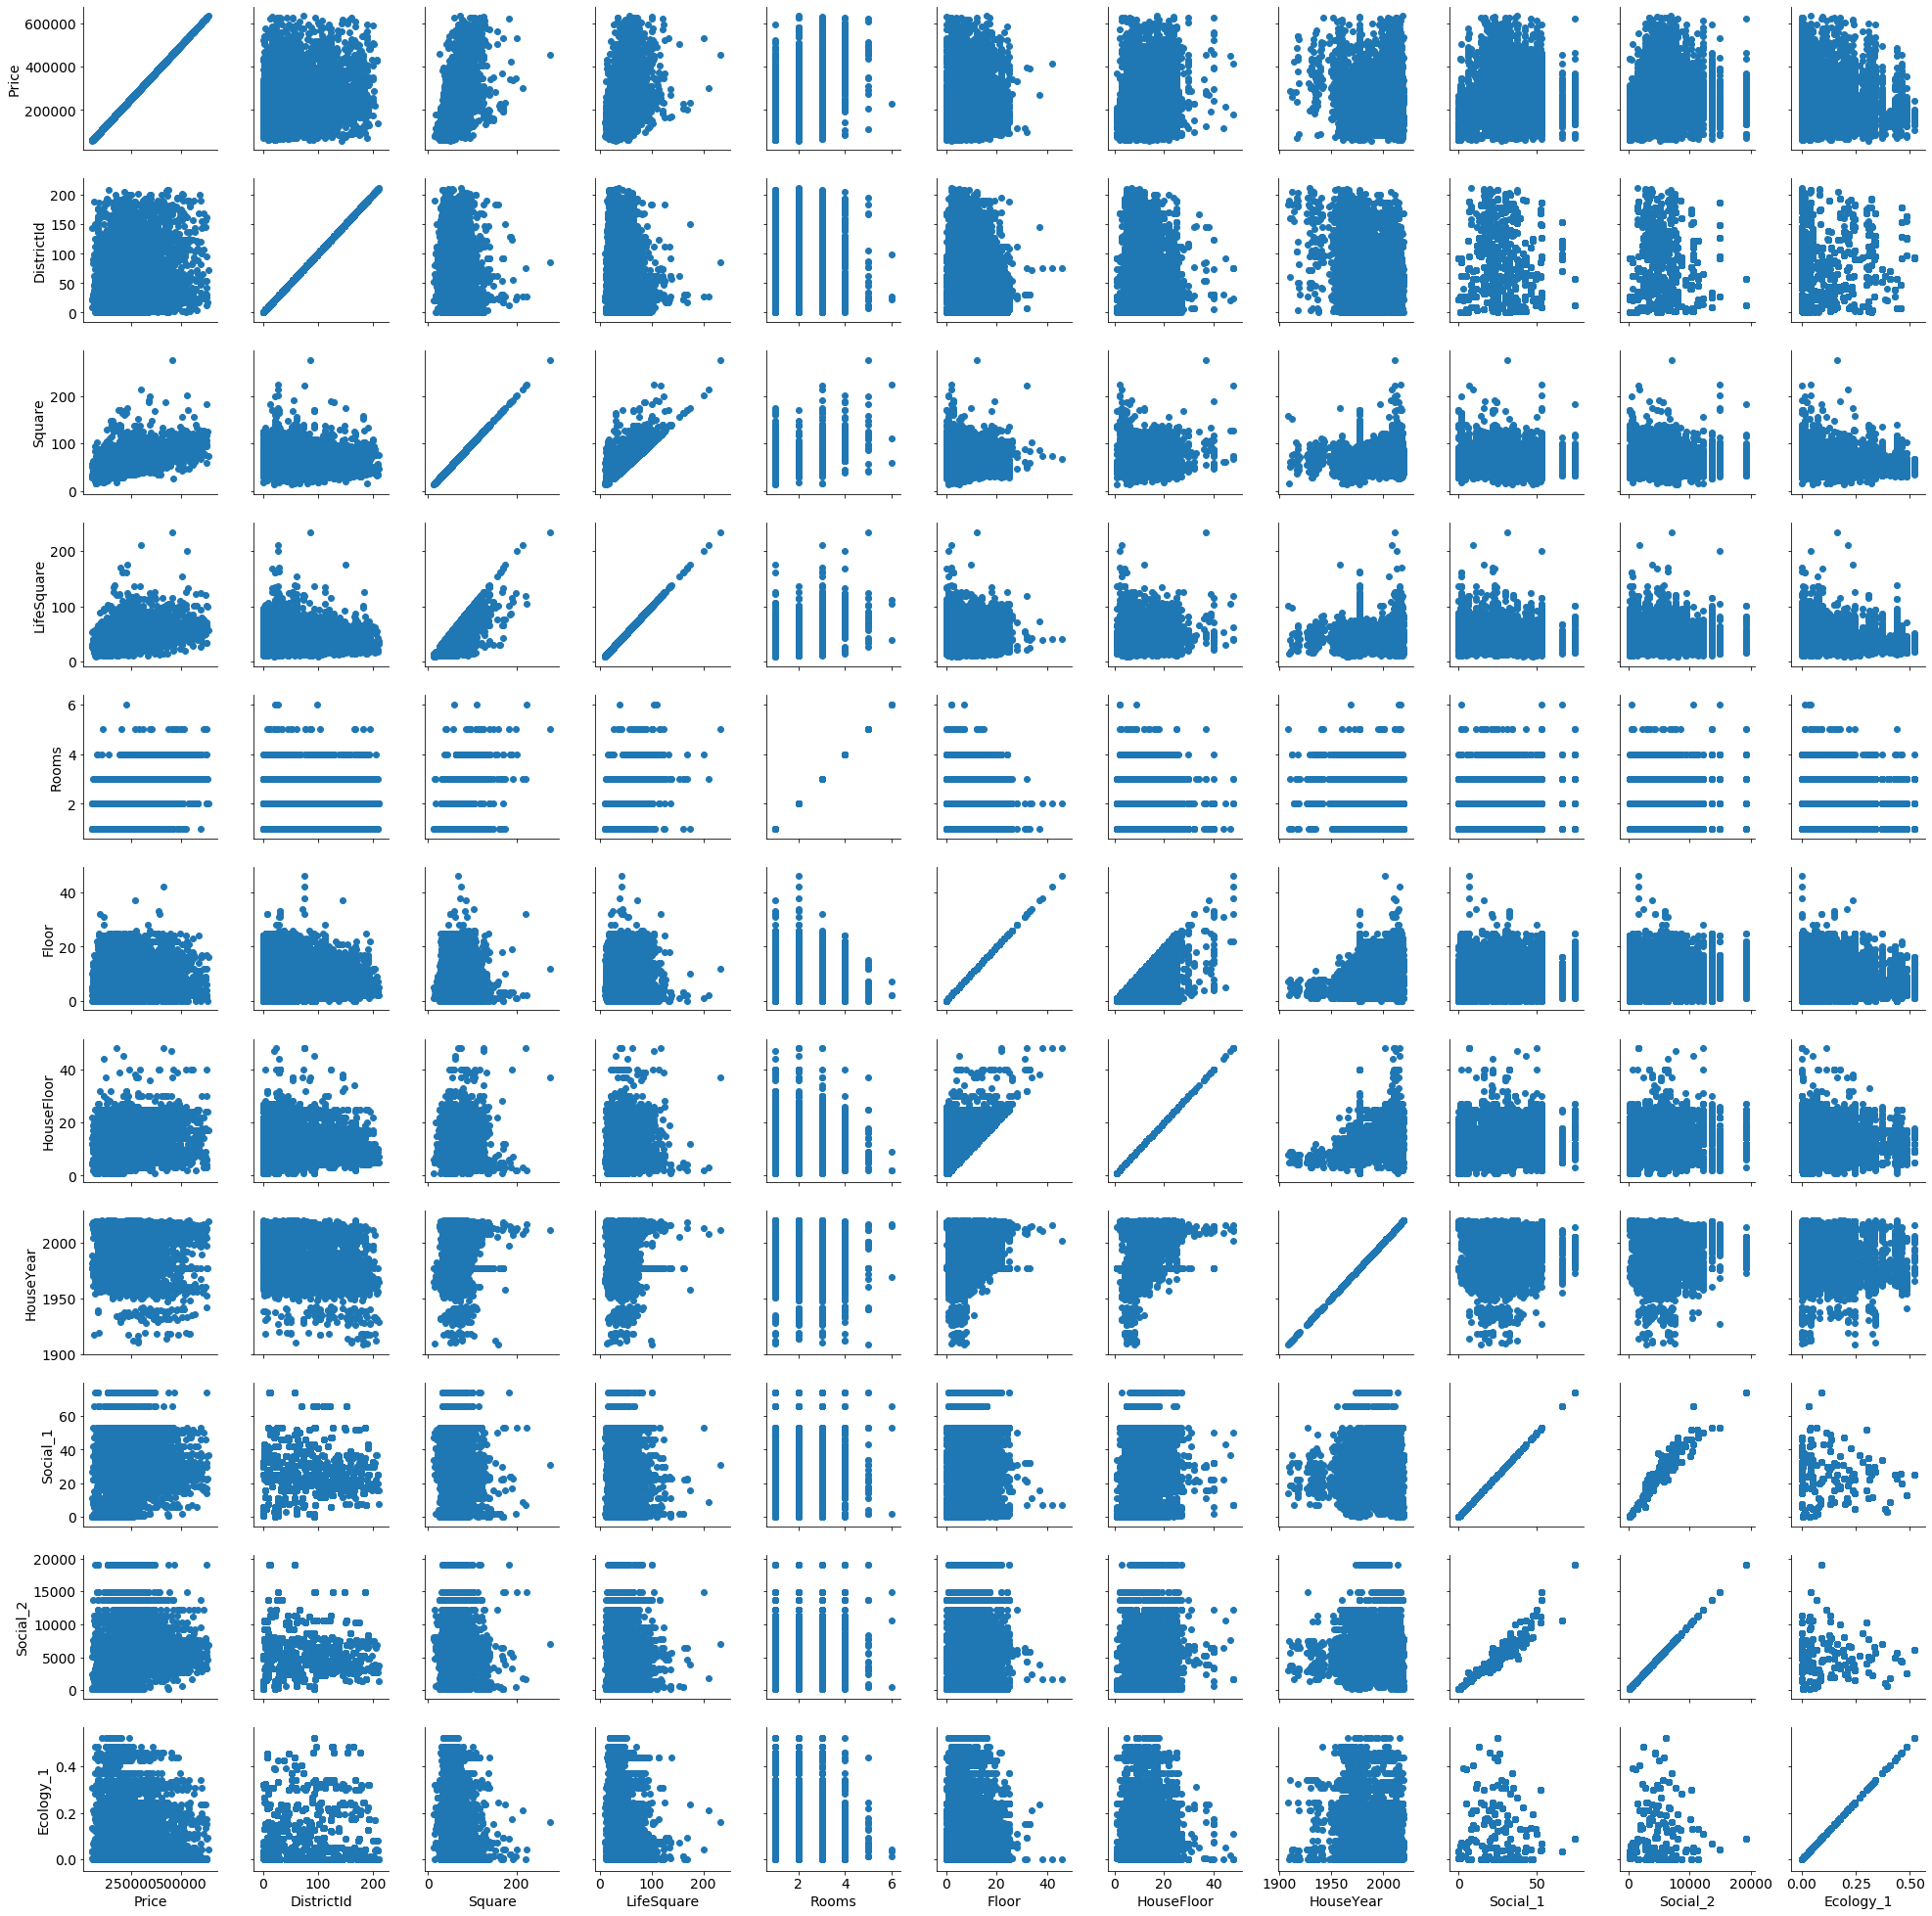

In [384]:
features = ['Price','DistrictId', 'Square', 'LifeSquare', 'Rooms', 'Floor', 'HouseFloor', 'HouseYear', 'Social_1', 'Social_2', 'Ecology_1']

g = sns.PairGrid(df[features])
g.map(plt.scatter)

In [386]:
display(df.Social_1.describe(), df.Social_2.describe())

count    15000.000000
mean        24.769267
std         17.532278
min          0.000000
25%          6.000000
50%         25.000000
75%         36.000000
max         74.000000
Name: Social_1, dtype: float64

count    15000.000000
mean      5370.404933
std       4013.364403
min        168.000000
25%       1564.000000
50%       5285.000000
75%       7287.000000
max      19083.000000
Name: Social_2, dtype: float64

## Снова разбиваю на трейн и тест датафреймы

In [530]:
df.columns

Index(['Base', 'DistrictId', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Floor',
       'Helthcare_2', 'HouseFloor', 'HouseYear', 'Id', 'LifeSquare', 'Price',
       'Rooms', 'Shops_1', 'Shops_2', 'Social_1', 'Social_2', 'Social_3',
       'Square', 'Kitchen1', 'Kitchen2', 'Kitchen3', 'Mean_room_square',
       'Mean_room_Lsquare', 'Price_per_square', 'Median_pps_per_district',
       'Median_pps_per_Hyear', 'Median_pps_per_Hfloor',
       'Median_pps_per_NRooms', 'Price_per_Lifesquare',
       'Median_ppls_per_district', 'Median_ppls_per_Hyear',
       'Median_ppls_per_Hfloor', 'Median_ppls_per_NRooms',
       'Med_price_per_district', 'Med_price_per_Hyear', 'Med_price_per_Hfloor',
       'Med_price_per_NRooms'],
      dtype='object')

In [550]:
remain = ['DistrictId', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Floor',
       'Helthcare_2', 'HouseFloor', 'HouseYear', 'LifeSquare', 'Rooms', 
        'Shops_1', 'Shops_2', 'Social_1', 'Social_2', 'Social_3',
       'Square', 'Kitchen1', 'Kitchen2', 'Kitchen3', 'Mean_room_square',
       'Mean_room_Lsquare', 'Median_pps_per_district',
       'Median_pps_per_Hyear', 'Median_pps_per_Hfloor',
       'Median_pps_per_NRooms', 'Median_ppls_per_district', 'Median_ppls_per_Hyear',
       'Median_ppls_per_Hfloor', 'Median_ppls_per_NRooms',
       'Med_price_per_district', 'Med_price_per_Hyear', 'Med_price_per_Hfloor',
       'Med_price_per_NRooms']

x_train = df[df['Base']=='train']
y_train = x_train.Price
x_test = df[df['Base']=='test']
x_test_id = x_test.Id

x_train = x_train[remain]
x_test = x_test[remain]

In [551]:
scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

colnames = ['Social_1', 'Social_2']
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train[colnames]), columns=colnames)
x_test_scaled = pd.DataFrame(scaler.transform(x_test[colnames]), columns=colnames)
x_train_scaled.head()

,Social_1,Social_2
0,0.445946,0.412794
1,0.621622,0.536135
2,0.459459,0.401322
3,0.310811,0.294317
4,0.472973,0.296484


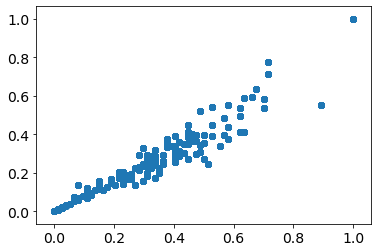

In [552]:
plt.scatter(x_train_scaled.Social_1, x_train_scaled.Social_2)
plt.show()

In [553]:
x_train['Social_12'] = x_train_scaled['Social_1'] + x_train_scaled['Social_2']
x_test['Social_12'] = x_test['Social_1'] + x_test['Social_2']

In [554]:
x_train = x_train.drop(columns=['Social_1', 'Social_2'])
x_test = x_test.drop(columns=['Social_1', 'Social_2'])

## Моделирование

In [555]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [574]:
model = LGBMRegressor(criterion='r2',
                            max_depth=5,
                            min_samples_leaf=10,
                            random_state=42,  

                            n_estimators=400)

cv_score = cross_val_score(model, x_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))

mean = cv_score.mean()
std = cv_score.std()
display(mean, std)

0.7573632381280418

0.020512386006288547

R2:	0.91
RMSE:	27902.422
MSE:	778545128.529


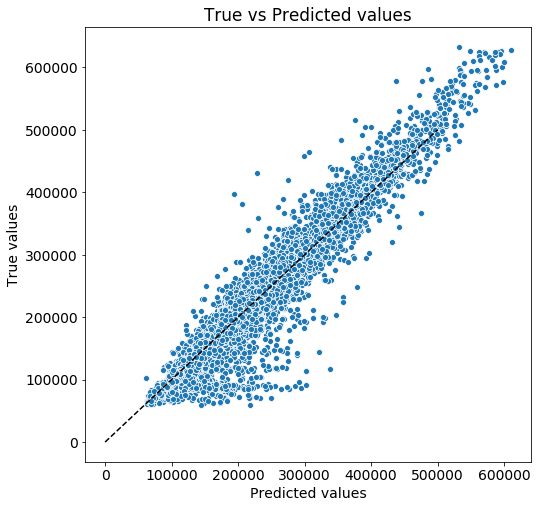

In [575]:
model.fit(x_train, y_train)

y_train_preds = model.predict(x_train)
evaluate_preds(y_train, y_train_preds)

In [576]:
feature_importances = pd.DataFrame(zip(x_train.columns, 
                                       model.feature_importances_ / model.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
13,Square,0.115635
19,Median_pps_per_district,0.075461
17,Mean_room_square,0.073561
18,Mean_room_Lsquare,0.065961
8,LifeSquare,0.065418
27,Med_price_per_district,0.061211
1,Ecology_1,0.054832
4,Floor,0.053746
28,Med_price_per_Hyear,0.053339
0,DistrictId,0.052796


In [585]:
to_delete = ['Median_ppls_per_district', 'Median_ppls_per_Hyear', 'Median_ppls_per_Hfloor', 
             'Median_ppls_per_NRooms', 'Ecology_2', 'Med_price_per_NRooms', 'Ecology_3', 'Shops_2', 'Kitchen1']

R2:	0.909
RMSE:	27957.947
MSE:	781646802.732


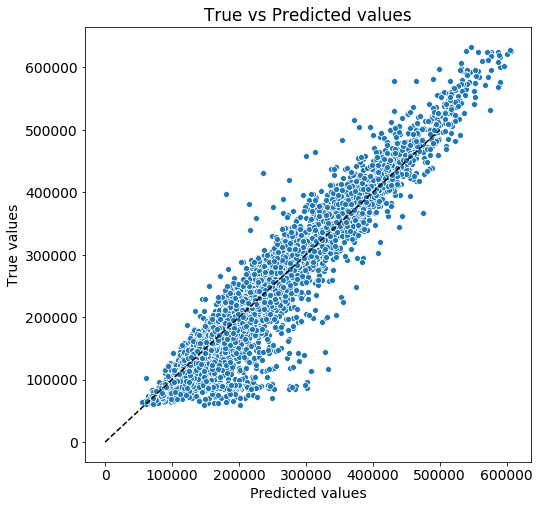

In [586]:
model.fit(x_train.drop(columns = to_delete, axis = 1), y_train)

y_train_preds = model.predict(x_train.drop(columns = to_delete, axis = 1))
evaluate_preds(y_train, y_train_preds)

In [570]:
# cv_score = cross_val_score(model, x_train.drop(columns = to_delete, axis = 1), y_train, 
#                            scoring='r2', 
#                            cv=KFold(n_splits=5, shuffle=True, random_state=42))

# mean = cv_score.mean()
# std = cv_score.std()
# display(mean, std)

0.7570202095158176

0.020841568812028703

**Без убирания фичей средний R2 скор был на тысячные лучше**

In [577]:
params = {'n_estimators':[50, 100, 300, 200, 400], 
          'max_depth':[3, 5, 6, 7, 10]}

gs = GridSearchCV(model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
gs.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, criterion='r2',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=5, min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_samples_leaf=10, min_split_gain=0.0,
                                     n_estimators=400, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3,

In [578]:
display(gs.best_params_, gs.best_score_)

{'max_depth': 5, 'n_estimators': 200}

0.7624997293197472

In [579]:
model2 = LGBMRegressor(criterion='r2',
                            max_depth=5,
                            min_samples_leaf=10,
                            random_state=42,  

                            n_estimators=200)

cv_score = cross_val_score(model2, x_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))

mean = cv_score.mean()
std = cv_score.std()
display(mean, std)

0.7619317655902045

0.02035053521367277

**Первоначальный вариант с n_estimators=400 - лучше**

In [580]:
with open(data_folder / 'final_model_29Apr.pkl', 'wb') as file:
   pickle.dump(model, file)

In [588]:
y_test_preds = model.predict(x_test)
final_df = pd.DataFrame({'Id': x_test_id, 'Price': y_test_preds})
final_df.head()

,Id,Price
0,725,183526.724389
1,15856,245993.223874
2,5480,188504.105432
3,15664,317173.827946
4,14275,166286.461146


In [589]:
final_df.to_csv(data_folder / 'result_29Apr.csv', index=False)